In [392]:
import numpy as np
import random
import scipy.integrate as scp
import numpy.random as rnd
import time
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy
from matplotlib.pyplot import figure
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import pickle
import scipy.stats
from math import comb
from numpy.polynomial import polynomial as P

eps  = np.finfo(float).eps
np.random.seed(1)

Gneneration of 3 sets of experimental data with different nitrate and light intensity, varies from low to high, number of datapoints for each exps is 26, noise level is 5% of means.

In [393]:
''' Data treatment'''
def save_pkl(item, fname):
    sn = 'tmp25/' + fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    print(f'Loaded from: {fname}')
    return ans

In [394]:
def to_dict(x,dt):
    obs = list(x)
    # tp = list(time)
    dicx = {}
    for i in range(len(x)):
        dicx[dt*i] = obs[i]          
    return dicx

def get_grad(x, t):
    dxdt = [[],[],[],[]]
    for n in range(x.shape[0]):
        for i in range(len(x[0]) - 1):
            dxdt[n].append((x[n][i + 1] - x[n][i])/(t[i + 1] - t[i]))
        dxdt[n].append(dxdt[n][-1])
    return dxdt


In [395]:
tf    = 240
# tf    = 16*24
steps_= 24
dt    = tf/steps_ #dt is fixed


num_N = 4
tf_N  = tf/(num_N) # tf_N is fixed
dt_N = 0.5
t_N = np.arange(0,tf_N+dt_N,dt_N)

dstep_N = len(t_N)# this is the number of steps in each interval between chaning the fedding rate

In [396]:
tf_N/dt


6.0

In [397]:
t = np.linspace(0, 240, num=25)

In [398]:
t

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240.])

In [399]:
t_simulation = np.arange(0,tf+dt_N,dt_N)

In [400]:
t_simulation

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,

In [401]:
t_fn1 = np.arange(0,tf/steps_+dt_N,dt_N)

In [402]:
for i in range(len(t)):
    print(t_simulation[(len(t_fn1)-1)*i])

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0
190.0
200.0
210.0
220.0
230.0
240.0


In [403]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=1, scramble=False)
u_sample = sampler.random_base2(m=4)

u_l_bounds = [50]   # feeding N, I
u_u_bounds = [200]

u_con = qmc.scale(u_sample,u_l_bounds,u_u_bounds)

In [404]:
len(u_con)

16

In [405]:
u_con

array([[ 50.   ],
       [125.   ],
       [162.5  ],
       [ 87.5  ],
       [106.25 ],
       [181.25 ],
       [143.75 ],
       [ 68.75 ],
       [ 78.125],
       [153.125],
       [190.625],
       [115.625],
       [ 96.875],
       [171.875],
       [134.375],
       [ 59.375]])

In [406]:
u_con = [u_con[i:i+4] for i in range(0, len(u_con), 4)]

In [407]:
u_con

[array([[ 50. ],
        [125. ],
        [162.5],
        [ 87.5]]),
 array([[106.25],
        [181.25],
        [143.75],
        [ 68.75]]),
 array([[ 78.125],
        [153.125],
        [190.625],
        [115.625]]),
 array([[ 96.875],
        [171.875],
        [134.375],
        [ 59.375]])]

In [408]:
ini_sampler = qmc.Sobol(d=1, scramble=False)
ini_N_sample = ini_sampler.random_base2(m=2)

initial_l_bounds = [15]   #initial N
initial_u_bounds = [60]
operation_con = qmc.scale(ini_N_sample,initial_l_bounds,initial_u_bounds)

In [409]:
operation_con

array([[15.  ],
       [37.5 ],
       [48.75],
       [26.25]])

In [410]:
# N_range = load_pkl('operation data/N_range.pkl')
# I0_range = load_pkl('operation data/I0_range.pkl')



# I1 = I0_range[0]
# I2 = I0_range[1]
# I3 = I0_range[2]

# I_max = np.max([I1,I2,I3])

# I_all = np.array([I1,I2,I3])

In [411]:
class ModelIntegration:
    
    # --- Initialize model --- #
    def __init__(self, parameters):

        # Object variable definitions
        self.parameters  =  parameters
        # self.dt, self.tf =  dt, tf
        
    # --- Dynamic model definition --- #    
    def model(self, t, state):
        # Internal definitions
        params = self.parameters
        
        # State vector
        x = state[0]
        n = state[1]
        q = state[2]
        f = state[3]

        I0      = params['I0']
        
        # Parameters

        kq      = params['kq']
        ud      = params['ud']
        un      = params['un']
        kn      = params['kn']
        theta   = params['theta']
        gamma   = params['gamma']
        epsilon = params['epsilon']
        
        tau     = params['tau']
        delta   = params['delta']
        phi     = params['phi']
        ks      = params['ks']
        ki      = params['ki']
        alpha   = params['alpha']
        belta   = params['belta']
        uM      = params['uM']  
        
        
        
        # Algebraic equations, calculation of um
         #Initial of L and I
        L         = 4.4E-2
        # I0      = 80
        def I_e(z):

            I_z   = I0*np.exp(-(alpha*x+belta)*z) 
            I     = uM*I_z/(I_z+ks+I_z**2/ki)
            return I





        um    = scp.quad(I_e, 0, L)
        um    = um[0]/L
  

        u0     = um*(1-kq/q)
        
        
        # Differential equations
        dev_x  = u0*x-ud*x
        dev_n  = -un*(n/(n+kn))*x
        dev_q  = un*(n/(n+kn)) - (u0-ud)*q
        dev_f  = u0*(theta*q-epsilon*f) - gamma*un*(n/(n+kn))+ud*epsilon*f
            
        # fluorescence
        Y      = (np.exp(tau*q)/(np.exp(tau*q)+delta))+phi

        return np.array([dev_x,dev_n,dev_q,dev_f], dtype='float64')
    
            # --- simulation --- #
    def simulation(self, dt, tf, x0):
        '''
        simulate for a number of steps to collect data, and a final time
        '''

        # external definitions
        self.x0, self.tf = x0, tf

        # internal definitions
        model = self.model
        steps    = int(tf/dt)
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt

    
    # # --- Simulation --- #
    # def simulation(self, initial_state):
    #     # Internal definitions
    #     steps   = int(self.tf/float(self.dt))
    #     model   = self.model
        
    #     # Compile state trajectories
    #     statet = np.zeros((initial_state.shape[0], steps + 1))
    #     tt     = np.zeros((steps+1))
        
    #     # Initialize simulation
    #     current_state = initial_state
    #     statet[:,0]   = current_state
    #     tt[0]         = 0.
        
    #     # Simulation
    #     for s in range(steps):
    #         ode           = scp.ode(model)                  # Define ode
    #         ode.set_integrator('lsoda', nsteps=3000)        # Define integrator
    #         ode.set_initial_value(current_state, dt)        # Set initial value
    #         current_state = list(ode.integrate(ode.t + dt)) # Integrate system
    #         statet[:,s+1] = current_state                   # Odd current state Note: here we can add randomnes as: + RandomNormal noise
    #         tt[s+1]       = (s+1)*dt
        
    #     return statet, tt   

In [412]:
tf_N

60.0

In [413]:
def train_data_generation(parameter, initial_c,mu_all):
    all_xt = []
    # all_pe = []
    # all_tt = []

    for i in range(len(mu_all)):
        # parameter['F_in'] = mu_all[i][0]
        # print(parameter['F_in'],'F_in')
        parameter['I0'] = mu_all[i]
        print(parameter['I0'],'I0')
        m            = ModelIntegration(parameter)
        xt_i, tt_i       = m.simulation(dt_N,tf_N,initial_c) 
        # xt_i, tt_i       = simulation(model, dstep_I,tf_I, initial_c,parameter)
        # print(xt_i.shape[1],'xt_i shape')
        all_xt.append(xt_i)
        # all_tt.append(tt_i)
        new_init = np.zeros(xt_i.shape[0])
        for j in range(xt_i.shape[0]):
            new_init[j] = xt_i[j][-1]
        initial_c = new_init
        # print(initial_c1,'initial_c1')

        # all_pe.append(parameter.copy())

    for i in range(1,len(all_xt)):
        all_xt[i] = np.delete(all_xt[i], 0, axis=1)


        # all_tt[i] = np.delete(all_tt[i], 0, axis=1)
    # print(all_xt,'all_xt')
    xt = all_xt[0]
    # tt = all_tt[0]

    # Iterate through the remaining arrays and concatenate them
    for i in all_xt[1:]:
        xt = np.concatenate((xt, i), axis=1)  # Concatenate along the rows

    
    mean_x = np.zeros(xt.shape[0])
    for i in range(xt.shape[0]):
        mean_x[i]=np.mean(xt[i])
        
    mean_x    = mean_x*0.05
    print(mean_x ,'mean_x')
    std_value = mean_x

    x_noise      = np.random.normal(0,mean_x[0],xt.shape[1])
    x_noise[0]   = 0
    n_noise      = np.random.normal(0,mean_x[1],xt.shape[1])
    n_noise[0]   = 0
    q_noise      = np.random.normal(0,mean_x[2],xt.shape[1])
    q_noise[0]   = 0
    f_noise      = np.random.normal(0,mean_x[3],xt.shape[1])
    f_noise[0]   = 0
    
    # V_noise      = np.random.normal(0,0,xt.shape[1])
    # V_noise[0]   = 0


    obs          = np.array([x_noise,n_noise,q_noise,f_noise])
    xobs         = xt+obs

    for i in range(xobs.shape[0]):
        for j in range(len(xobs[i])):
            if xobs[i][j]<0:
                xobs[i][j] = 1E-7
    for i in range(xobs.shape[1]):
        if xobs[0][i]<0:
            xobs[0][i] = 1e-7
        if xobs[1][i]<0:
            xobs[1][i] = 1e-7

    # return xt
    return xt,xobs,std_value

    # return xt

In [414]:
def data_correction(xt,t):
    xt_ = np.zeros([len(t),xt.shape[0]])
    for i in range(len(t)):
        # print((len(t_fn1)-1)*i)
        xt_[i] = xt.T[(len(t_fn1)-1)*i]
        # print(xt1_.T[(len(t_fn1)-1)*i])

    xt_ = xt_.T

    return xt_

In [415]:
operation_con

array([[15.  ],
       [37.5 ],
       [48.75],
       [26.25]])

In [416]:
u_con[0]

array([[ 50. ],
       [125. ],
       [162.5],
       [ 87.5]])

In [417]:
#experiment 1

p1  = {'uM' : 0.359,'kq':19.63,'ud':0., 'un':2.692,'kn':0.8,'theta':6.691,'gamma':7.53,'epsilon':0.001,'tau':0.138,'delta':9.904,'phi':-0.456,'ks':91.2,'ki':100,'alpha':196.4,'belta':0,'I0':u_con[0][0]}
initial_c1 = np.array([0.18,operation_con[0],80,120])  #
# xt1,tt1,xobs1_,std_value1_ = train_data_generation(p1, initial_c1,u_con[0])
xt1_,xobs1_,std_value1 = train_data_generation(p1, initial_c1,u_con[0])


C:\Users\wangh\AppData\Local\Temp\ipykernel_1988\1449168080.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_c1 = np.array([0.18,operation_con[0],80,120])  #


[50.] I0
[125.] I0
[162.5] I0
[87.5] I0
[ 0.05545322  0.03793327  1.57861651 20.11273696] mean_x


In [418]:
(xt1_>= 0).all()

True

In [419]:
xt1 = data_correction(xt1_,t)
xobs1 = data_correction(xobs1_,t)

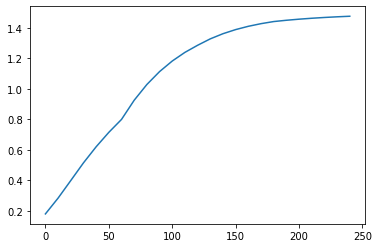

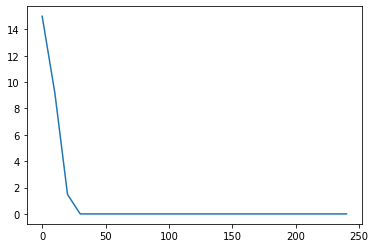

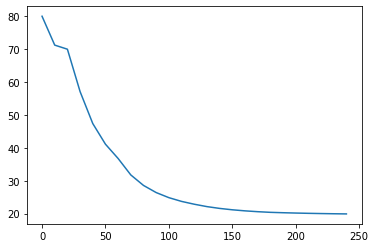

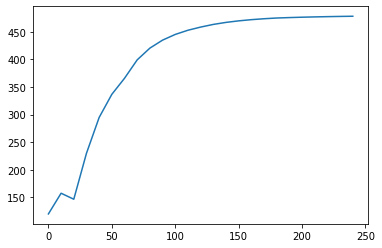

In [420]:

for i in range(xt1.shape[0]):
    plt.figure()
    plt.plot(t,xt1[i])
    plt.show()

In [421]:
#experiment 2

p2  = {'uM' : 0.359,'kq':19.63,'ud':0., 'un':2.692,'kn':0.8,'theta':6.691,'gamma':7.53,'epsilon':0.001,'tau':0.138,'delta':9.904,'phi':-0.456,'ks':91.2,'ki':100,'alpha':196.4,'belta':0,'I0':u_con[1][0]}
initial_c2 = np.array([0.18,operation_con[1],80,120])  #
# xt1,tt1,xobs1_,std_value1_ = train_data_generation(p1, initial_c1,u_con[0])
xt2_,xobs2_,std_value2 = train_data_generation(p2, initial_c2,u_con[1])


C:\Users\wangh\AppData\Local\Temp\ipykernel_1988\3696068051.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_c2 = np.array([0.18,operation_con[1],80,120])  #


[106.25] I0
[181.25] I0
[143.75] I0
[68.75] I0
[ 0.0868426   0.15355961  1.71124257 18.0310927 ] mean_x


In [422]:
u_con[1]

array([[106.25],
       [181.25],
       [143.75],
       [ 68.75]])

In [423]:
(xt2_>= 0).all()

True

In [424]:
xt2 = data_correction(xt2_,t)
xobs2 = data_correction(xobs2_,t)

In [425]:
xt2.shape

(4, 25)

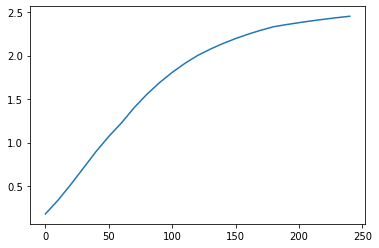

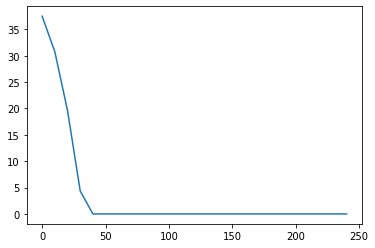

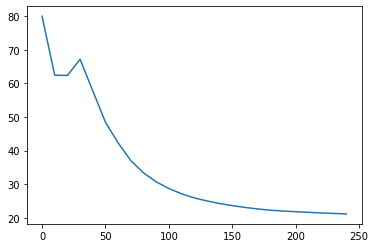

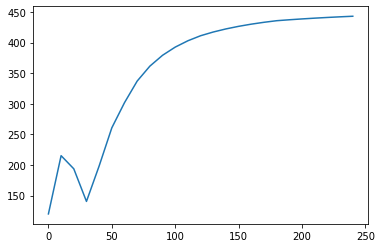

In [426]:
for i in range(xt2.shape[0]):
    plt.figure()
    plt.plot(t,xt2[i])
    plt.show()

In [427]:
#experiment 3

p3  = {'uM' : 0.359,'kq':19.63,'ud':0., 'un':2.692,'kn':0.8,'theta':6.691,'gamma':7.53,'epsilon':0.001,'tau':0.138,'delta':9.904,'phi':-0.456,'ks':91.2,'ki':100,'alpha':196.4,'belta':0,'I0':u_con[2][0]}
initial_c3 = np.array([0.18,operation_con[2],80,120])  #
# xt1,tt1,xobs1_,std_value1_ = train_data_generation(p1, initial_c1,u_con[0])
xt3_,xobs3_,std_value3 = train_data_generation(p3, initial_c3,u_con[2])




C:\Users\wangh\AppData\Local\Temp\ipykernel_1988\4106007803.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_c3 = np.array([0.18,operation_con[2],80,120])  #


[78.125] I0
[153.125] I0
[190.625] I0
[115.625] I0
[ 0.09298061  0.24619651  1.97059278 15.58484066] mean_x


In [428]:
(xt3_>= 0).all()

True

In [429]:
xt3 = data_correction(xt3_,t)
xobs3 = data_correction(xobs3_,t)

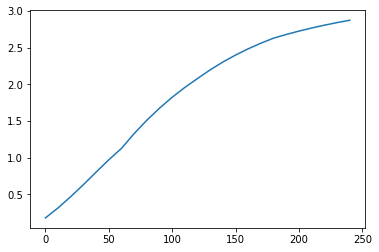

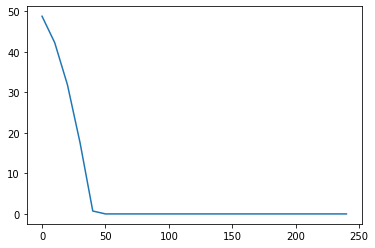

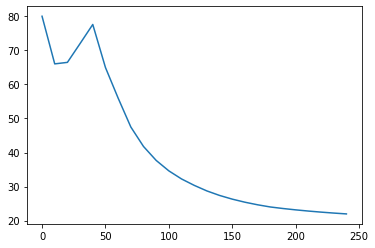

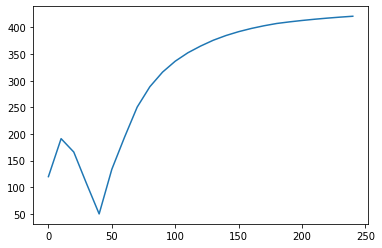

In [430]:
for i in range(xt3.shape[0]):
    plt.figure()
    plt.plot(t,xt3[i])
    plt.show()

In [431]:
#experiment 4

p4  = {'uM' : 0.359,'kq':19.63,'ud':0., 'un':2.692,'kn':0.8,'theta':6.691,'gamma':7.53,'epsilon':0.001,'tau':0.138,'delta':9.904,'phi':-0.456,'ks':91.2,'ki':100,'alpha':196.4,'belta':0,'I0':u_con[3][0]}
initial_c4 = np.array([0.18,operation_con[3],80,120])  #
# xt1,tt1,xobs1_,std_value1_ = train_data_generation(p1, initial_c1,u_con[0])
xt4_,xobs4_,std_value4 = train_data_generation(p4, initial_c4,u_con[3])




C:\Users\wangh\AppData\Local\Temp\ipykernel_1988\1373830772.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_c4 = np.array([0.18,operation_con[3],80,120])  #


[96.875] I0
[171.875] I0
[134.375] I0
[59.375] I0
[ 0.07411513  0.08708306  1.57836237 19.50459556] mean_x


In [432]:
(xt4_>= 0).all()

True

In [433]:
xt4 = data_correction(xt4_,t)
xobs4 = data_correction(xobs4_,t)

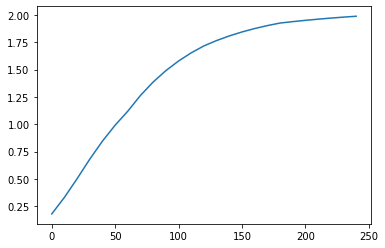

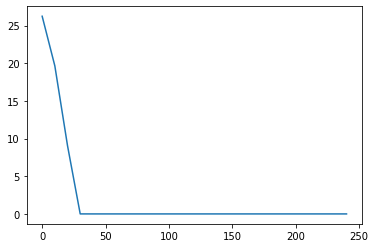

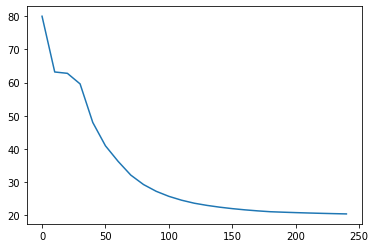

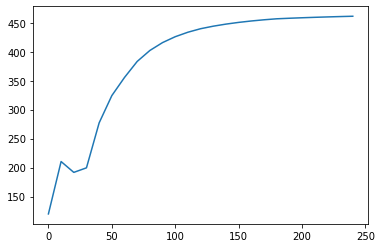

In [434]:
for i in range(xt4.shape[0]):
    plt.figure()
    plt.plot(t,xt4[i])
    plt.show()

In [435]:
def plot_data(x, y1,y2,name):
    fig = plt.figure()
    plt.plot(x, y1,'.')
    plt.plot(x, y2, '-',label=name)
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.legend(loc="lower right")
    fig.savefig(name)
    plt.show()
    return None
def check_plot(xobs,xt,tt):
    plot_data(tt, xobs[0],xt[0],'biomass')
    plot_data(tt, xobs[1],xt[1],'nitrate')
    plot_data(tt, xobs[2],xt[2],'quota')
    plot_data(tt, xobs[3],xt[3],'fame')
    return None

In [436]:
def plot_data(x, y1,y2,y1hat,y2hat,name,namehat):
    fig = plt.figure()
    plt.plot(x, y1,'.',color = 'red')
    plt.plot(x, y1hat,'.',color = 'blue')
    plt.plot(x, y2, '-',label=name)
    plt.plot(x, y2hat, '-',label=namehat)
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.legend(loc="lower right")
    # fig.savefig(name)
    plt.show()
    return None
def check_plot(xobs,xt,xobshat,xthat,tt,name1,name2):
    plot_data(tt, xobs[0],xt[0],xobshat[0],xthat[0],name1[0],name2[0])
    plot_data(tt, xobs[1],xt[1],xobshat[1],xthat[1],name1[1],name2[1])
    plot_data(tt, xobs[2],xt[2],xobshat[2],xthat[2],name1[2],name2[2])
    plot_data(tt, xobs[3],xt[3],xobshat[3],xthat[3],name1[3],name2[3])
    return None

In [437]:
u_con

[array([[ 50. ],
        [125. ],
        [162.5],
        [ 87.5]]),
 array([[106.25],
        [181.25],
        [143.75],
        [ 68.75]]),
 array([[ 78.125],
        [153.125],
        [190.625],
        [115.625]]),
 array([[ 96.875],
        [171.875],
        [134.375],
        [ 59.375]])]

In [438]:
def dic_I(no_data,num_u,u_con):
    u_test = np.ones([no_data,num_u])
    for i in range(len(t)):
        if t[i] >=0 and t[i] <=tf_N:
            u_test[i] = u_con[0]
        if t[i] >tf_N and t[i] <=2*tf_N:
            u_test[i] = u_con[1]
        if t[i] >2*tf_N and t[i] <=3*tf_N:
            u_test[i] = u_con[2]
        if t[i] >3*tf_N and t[i] <=4*tf_N:
            u_test[i] = u_con[3]
    # Insert the new element at the beginning of the array
    # u_test = np.vstack((new_element,u_test))

    F_in_dic = to_dict(u_test.T[0],dt)
    # I_dic    = to_dict(u_test.T[1],dt)

    return F_in_dic

In [439]:
# def dic_F_in_I(step,num_u,u_con):
#     u_test = np.ones([step,num_u])
#     for i in range(4):
#         for j in range(6):
#             u_test[i*6 + j] = u_con[i]
#     new_element = u_con[0]

#     # Insert the new element at the beginning of the array
#     u_test = np.vstack((new_element,u_test))
#     print(u_test.T,'u_test.T')

#     # F_in_dic = to_dict(u_test.T[0],dt)
#     I_dic    = to_dict(u_test[0].T,dt)

    
#     return I_dic

#     # return F_in_dic, I_dic
        


In [440]:
    # u_test = np.ones([step,num_u])
    # for i in range(4):
    #     for j in range(6):
    #         u_test[i*6 + j] = u_con[0][i]
    # new_element = u_con[0][0]

    # # Insert the new element at the beginning of the array
    # u_test = np.vstack((new_element,u_test))

In [441]:
u_con[0]

array([[ 50. ],
       [125. ],
       [162.5],
       [ 87.5]])

In [442]:
u_dic1 = dic_I(25,1,u_con[0])
u_dic2 = dic_I(25,1,u_con[1])
u_dic3 = dic_I(25,1,u_con[2])
u_dic4 = dic_I(25,1,u_con[3])


In [443]:
u_dic1 

{0.0: 50.0,
 10.0: 50.0,
 20.0: 50.0,
 30.0: 50.0,
 40.0: 50.0,
 50.0: 50.0,
 60.0: 50.0,
 70.0: 125.0,
 80.0: 125.0,
 90.0: 125.0,
 100.0: 125.0,
 110.0: 125.0,
 120.0: 125.0,
 130.0: 162.5,
 140.0: 162.5,
 150.0: 162.5,
 160.0: 162.5,
 170.0: 162.5,
 180.0: 162.5,
 190.0: 87.5,
 200.0: 87.5,
 210.0: 87.5,
 220.0: 87.5,
 230.0: 87.5,
 240.0: 87.5}

In [444]:
u_dic4

{0.0: 96.875,
 10.0: 96.875,
 20.0: 96.875,
 30.0: 96.875,
 40.0: 96.875,
 50.0: 96.875,
 60.0: 96.875,
 70.0: 171.875,
 80.0: 171.875,
 90.0: 171.875,
 100.0: 171.875,
 110.0: 171.875,
 120.0: 171.875,
 130.0: 134.375,
 140.0: 134.375,
 150.0: 134.375,
 160.0: 134.375,
 170.0: 134.375,
 180.0: 134.375,
 190.0: 59.375,
 200.0: 59.375,
 210.0: 59.375,
 220.0: 59.375,
 230.0: 59.375,
 240.0: 59.375}

In [445]:
data_init   = {None: dict(t       = {None: list(t)},tm      = {None: list(t)},x1_noise = to_dict(xobs1[0],dt),n1_noise = to_dict(xobs1[1],dt),q1_noise = to_dict(xobs1[2],dt),f1_noise = to_dict(xobs1[3],dt),x2_noise = to_dict(xobs2[0],dt),n2_noise = to_dict(xobs2[1],dt),q2_noise = to_dict(xobs2[2],dt),f2_noise = to_dict(xobs2[3],dt),x3_noise = to_dict(xobs3[0],dt),n3_noise = to_dict(xobs3[1],dt),q3_noise = to_dict(xobs3[2],dt),f3_noise = to_dict(xobs3[3],dt),x4_noise = to_dict(xobs4[0],dt),n4_noise = to_dict(xobs4[1],dt),q4_noise = to_dict(xobs4[2],dt),f4_noise = to_dict(xobs4[3],dt))}

In [446]:
data_init

{None: {'t': {None: [0.0,
    10.0,
    20.0,
    30.0,
    40.0,
    50.0,
    60.0,
    70.0,
    80.0,
    90.0,
    100.0,
    110.0,
    120.0,
    130.0,
    140.0,
    150.0,
    160.0,
    170.0,
    180.0,
    190.0,
    200.0,
    210.0,
    220.0,
    230.0,
    240.0]},
  'tm': {None: [0.0,
    10.0,
    20.0,
    30.0,
    40.0,
    50.0,
    60.0,
    70.0,
    80.0,
    90.0,
    100.0,
    110.0,
    120.0,
    130.0,
    140.0,
    150.0,
    160.0,
    170.0,
    180.0,
    190.0,
    200.0,
    210.0,
    220.0,
    230.0,
    240.0]},
  'x1_noise': {0.0: 0.18,
   10.0: 0.22282356533121636,
   20.0: 0.3884461274741864,
   30.0: 0.4731542776451567,
   40.0: 0.6082363901277796,
   50.0: 0.6905292550920789,
   60.0: 0.7986625995832054,
   70.0: 0.9156086295508562,
   80.0: 1.0005432081109003,
   90.0: 1.0432792294587738,
   100.0: 1.1609616589706404,
   110.0: 1.3296742728610913,
   120.0: 1.258933184531873,
   130.0: 1.334642899263699,
   140.0: 1.3191513184701842,
   

In [447]:
u_con

[array([[ 50. ],
        [125. ],
        [162.5],
        [ 87.5]]),
 array([[106.25],
        [181.25],
        [143.75],
        [ 68.75]]),
 array([[ 78.125],
        [153.125],
        [190.625],
        [115.625]]),
 array([[ 96.875],
        [171.875],
        [134.375],
        [ 59.375]])]

In [448]:
operation_con

array([[15.  ],
       [37.5 ],
       [48.75],
       [26.25]])

In [449]:
N_in = 100

In [450]:
xobs1.shape

(4, 25)

In [451]:
save_pkl(xobs1,'xobs1.pkl')
save_pkl(xobs2,'xobs2.pkl')
save_pkl(xobs3,'xobs3.pkl')
save_pkl(xobs4,'xobs4.pkl')
save_pkl(tf_N,'tf_N.pkl')
save_pkl(u_con,'u_con.pkl')
save_pkl(N_in,'N_in.pkl')
# save_pkl(xobs5,'xobs5.pkl')

save_pkl(operation_con,'operation_con.pkl')
# save_pkl(I0_range,'I0_range.pkl')

save_pkl(t,'tt1.pkl')
save_pkl(std_value1,'std_value1.pkl')
save_pkl(std_value2,'std_value2.pkl')
save_pkl(std_value3,'std_value3.pkl')
save_pkl(std_value4,'std_value4.pkl')

save_pkl(data_init,'data_init.pkl')

save_pkl(u_dic1,'u_dic1.pkl')
save_pkl(u_dic2,'u_dic2.pkl')
save_pkl(u_dic3,'u_dic3.pkl')
save_pkl(u_dic4,'u_dic4.pkl')


File saved at: tmp25/xobs1.pkl
File saved at: tmp25/xobs2.pkl
File saved at: tmp25/xobs3.pkl
File saved at: tmp25/xobs4.pkl
File saved at: tmp25/tf_N.pkl
File saved at: tmp25/u_con.pkl
File saved at: tmp25/N_in.pkl
File saved at: tmp25/operation_con.pkl
File saved at: tmp25/tt1.pkl
File saved at: tmp25/std_value1.pkl
File saved at: tmp25/std_value2.pkl
File saved at: tmp25/std_value3.pkl
File saved at: tmp25/std_value4.pkl
File saved at: tmp25/data_init.pkl
File saved at: tmp25/u_dic1.pkl
File saved at: tmp25/u_dic2.pkl
File saved at: tmp25/u_dic3.pkl
File saved at: tmp25/u_dic4.pkl
